In [3]:
import numpy as np
import scipy.io
import seaborn as sns

from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns # named from Samuel Norman "Sam" Seaborn is a fictional character portrayed by Rob Lowe on the television serial drama The West Wing.
import pandas as pd
import os
import time
import matplotlib.ticker as mtick
from pathlib import Path

#directory = '/Users/mkals/data/OximeterTestingData/Logs'
directory = '/Users/mkals/Developer/Cambridge/OximeterTesting/Data/Logs'

def severinghaus(x):
    if x == 0:
        return 0
    return ((((x**3+150*x)**-1 * 23400)+1)**-1) * 100

# data: full list to be processed
# splits: numeber of consecutive elements to be processed
# func: lambda function that takes the subset and returns what should be stored in return array
def map_reduce(data, splits, func):
    data = list(data)
    return [func(data[i:i + splits]) for i in range(len(data) - splits + 1)]

def plot_pressure(df, new=True):
    if new:
        plt.figure()

    title = 'pressure'
    #df.drop(df.iloc[:1000,:].index.tolist(), inplace=True)
    plt.plot(df.utc_time, df.p)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Pressure (atm)')
    plt.gca().xaxis.set_major_formatter(
        mtick.FuncFormatter(lambda pos,_: time.strftime("%d-%m-%Y %H:%M:%S",time.localtime(pos)))
    )

def plot_processed(df, new=True):
    if new:
        plt.figure()

    title = 'processed'
    #df.drop(df.iloc[:1000,:].index.tolist(), inplace=True)
    plt.plot(df.utc_time, df.red_sig)
    plt.plot(df.utc_time, df.ir_sig)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend(['r', 'i'])

def plot_raw(df, new=True):
    if new:
        plt.figure()

    title = 'raw'
    #df.drop(df.iloc[:1000,:].index.tolist(), inplace=True)
    plt.plot(df.utc_time, df.r)
    plt.plot(df.utc_time, df.i)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend(['r', 'i'])

def plot_bath_summary(df):

    period = 2
    mesurement_interval = (
        df.utc_time.iloc[-1] - df.utc_time.iloc[0]) / df.shape[0]
    point_count = int(period / mesurement_interval)

    times = map_reduce(df['utc_time'], point_count, np.mean)
    dc_r = map_reduce(df.r, point_count, np.mean)
    dc_i = map_reduce(df.i, point_count, np.mean)
    ac_r = map_reduce(df.r, point_count, (lambda x: max(x) - min(x)))
    ac_i = map_reduce(df.i, point_count, (lambda x: max(x) - min(x)))

    dc_r_mean = np.mean(dc_r)
    dc_i_mean = np.mean(dc_i)
    ac_r_mean = np.mean(ac_r)
    ac_i_mean = np.mean(ac_i)

    print(f'DC Red = {dc_r_mean:.0f}')
    print(f'DC IR  = {dc_i_mean:.0f}')
    print(f'AC Red = {ac_r_mean:.0f}')
    print(f'AC IR  = {ac_i_mean:.0f}')

    f, (ax1, ax2) = plt.subplots(1, 2)  # , sharey=True)

    # DC PLOT
    ax1.plot(df.utc_time, df.r)
    ax1.plot(df.utc_time, df.i)
    ax1.plot(times, dc_r, '-')
    ax1.plot(times, dc_i, '-')
    ax1.axhline(dc_r_mean)
    ax1.axhline(dc_i_mean)

    ax1.set_title('DC Bath Data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Signal')
    ax1.legend(['r', 'i', 'r ra', 'i ra', 'r mean', 'i mean'])

    # AC PLOT
    ax2.plot(times, ac_r)
    ax2.plot(times, ac_i)
    ax2.axhline(ac_r_mean)
    ax2.axhline(ac_i_mean)

    ax2.set_title('AC')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Signal')
    ax2.legend(['r', 'i', 'r mean', 'i mean'])

    plt.figure()
    plt.plot(df.utc_time, df.SPO2)
    plt.plot(df.utc_time, df.SPO2Avg)
    plt.xlabel('Time')
    plt.ylabel('SpO2 %')

    plt.show()

def add_normalized_time(df):
    df['name'] = df['utc_time']-df['utc_time'][0]

In [23]:
# Load files from disk and plot latest

MIN_FILESIZE = 1000

fs = [f'{directory}/{f}' for f in os.listdir(directory)]
csv_files = [f for f in fs if '.csv' in f[-5:]]
csv_files.sort()
print(csv_files[-1])

# sync up b and p files based on filename timestamp
b_files = [f for f in csv_files if 'bath' in f]
p_files = [f for f in csv_files if 'pressure' in f]
matches = []
for b in b_files:
    for p in p_files:
        if b[-17:] in p:
            if Path(p).stat().st_size > MIN_FILESIZE and Path(b).stat().st_size > MIN_FILESIZE:
                matches.append((b,p))


def get_oxygenation_from_metadata(file):
    try:
        with open(file+'meta.txt', 'r') as f:
            return float(f.readline().split(',')[0])
    except:
        pass
    return 0

matches = [(a, pd.read_csv(a), pd.read_csv(b), get_oxygenation_from_metadata(a)) for a, b in matches]

/Users/mkals/Developer/Cambridge/OximeterTesting/Data/Logs/pressure_20210901_1808.csv


In [24]:
print(matches[0][1].head())
print(matches[0][2].head())

       utc_time  red  beat_red  pulse_red  pulse_red_threshold  red_sig  \
0  1.629368e+09 -4.0       0.0      100.0                 20.0     -4.0   
1  1.629368e+09 -2.0       0.0      100.0                 20.0     -2.0   
2  1.629368e+09  0.0       0.0      100.0                 20.0      0.0   
3  1.629368e+09  0.0       0.0      100.0                 20.0      0.0   
4  1.629368e+09  0.0       0.0      100.0                 20.0      0.0   

   ir_sig       r        i  SPO2  beatAvg  rollHrAvg  SPO2Avg  
0    -2.0  7564.0  46012.0   0.0      0.0        0.0      0.0  
1     0.0  7564.0  46004.0   0.0      0.0        0.0      0.0  
2     0.0  7561.0  46008.0   0.0      0.0        0.0      0.0  
3     0.0  7562.0  46009.0   0.0      0.0        0.0      0.0  
4    -1.0  7564.0  46014.0   0.0      0.0        0.0      0.0  
       utc_time     p
0  1.629368e+09  1.03
1  1.629368e+09  1.03
2  1.629368e+09  1.03
3  1.629368e+09  1.03
4  1.629368e+09  1.03


<ipython-input-33-ab20e196331b>:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, (ax1, ax2) = plt.subplots(2, 1)  # , sharey=True)


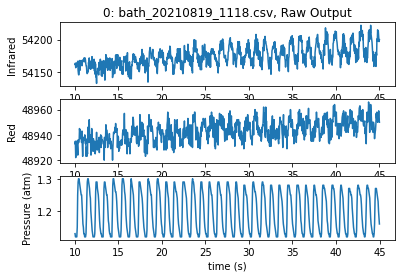

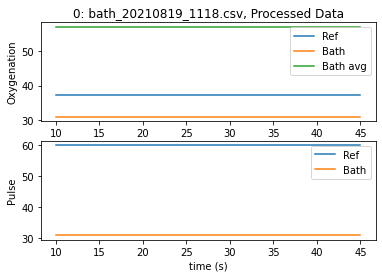

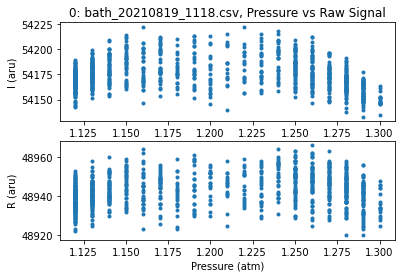

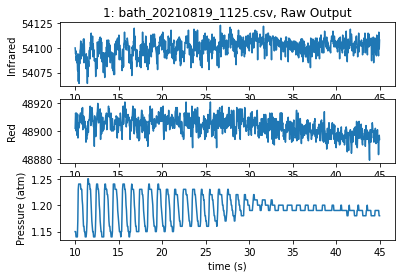

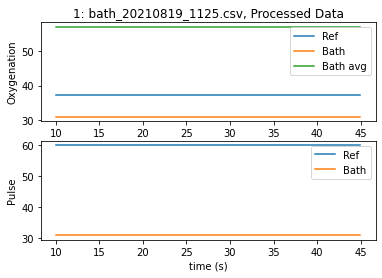

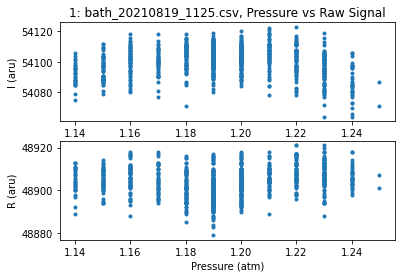

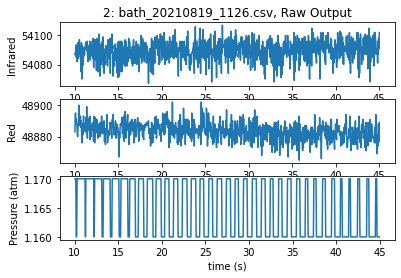

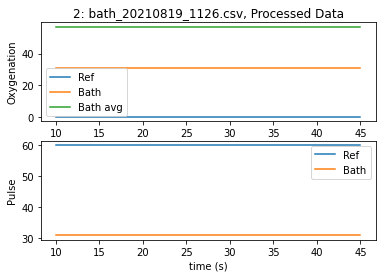

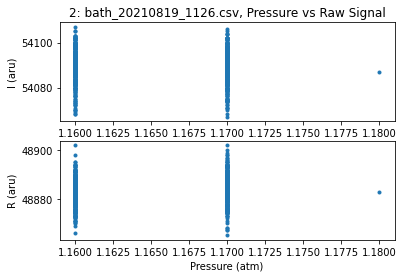

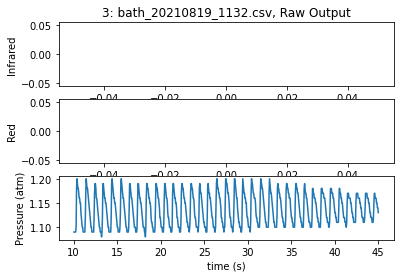

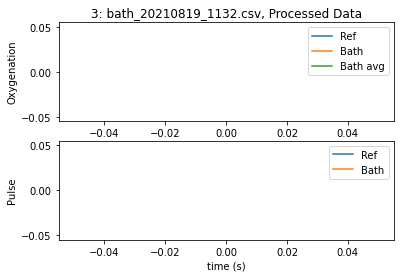

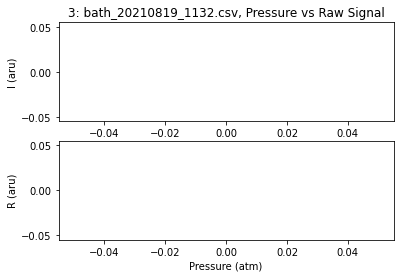

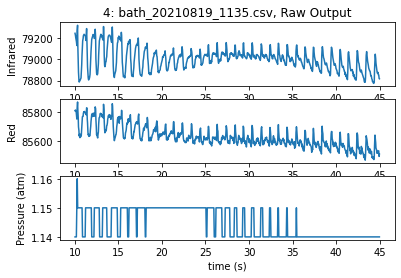

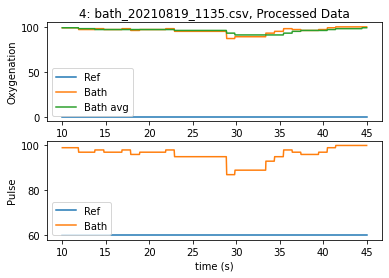

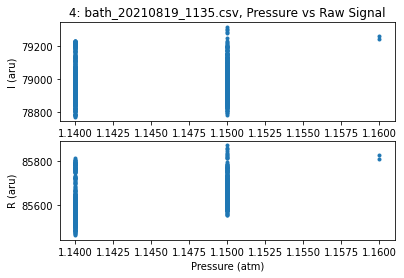

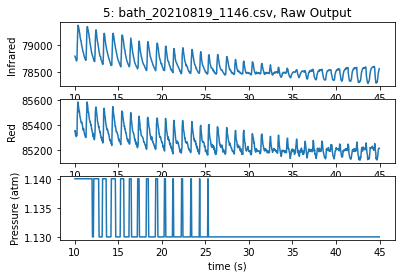

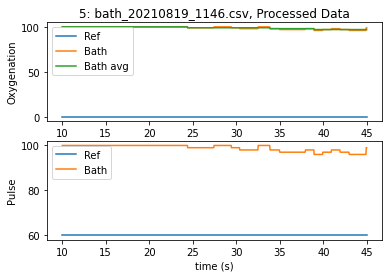

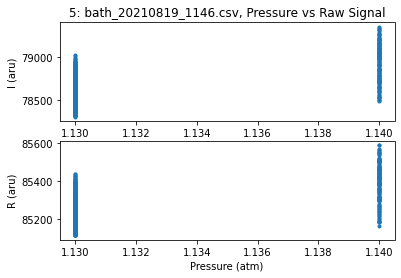

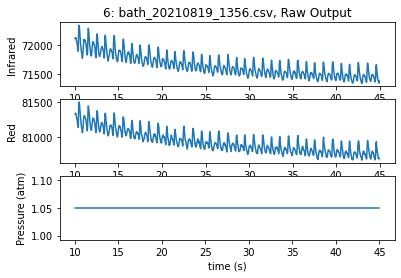

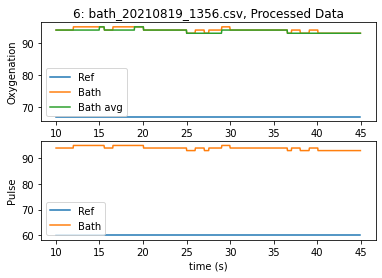

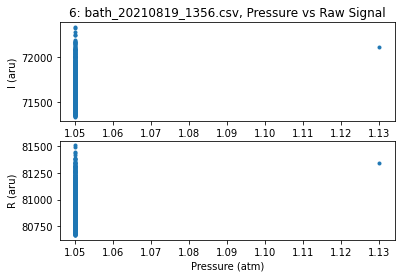

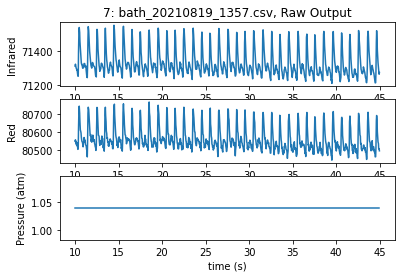

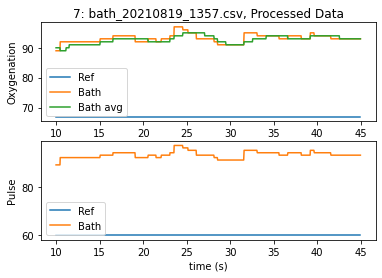

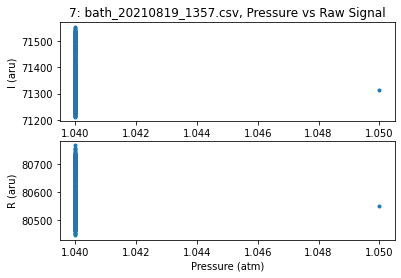

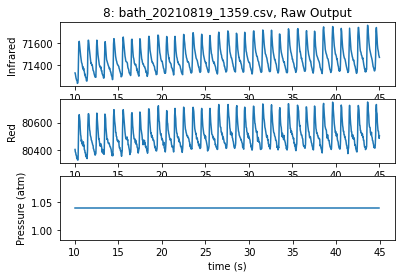

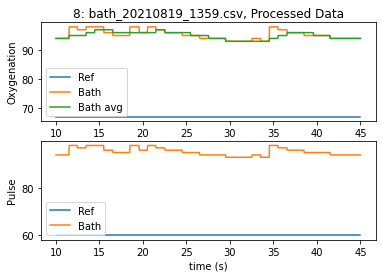

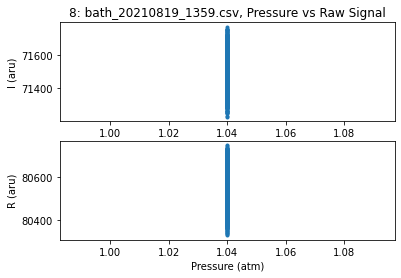

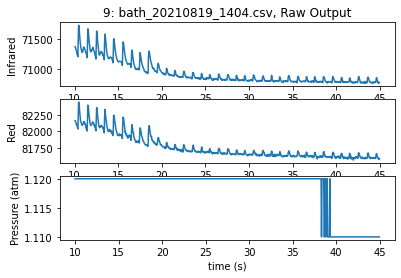

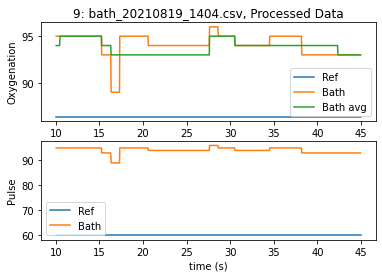

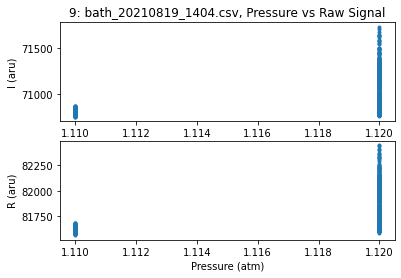

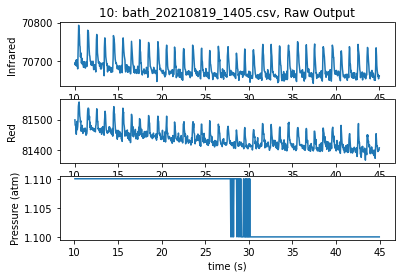

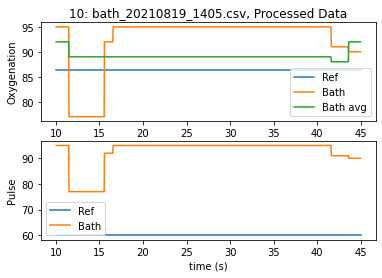

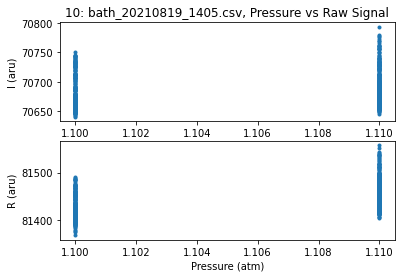

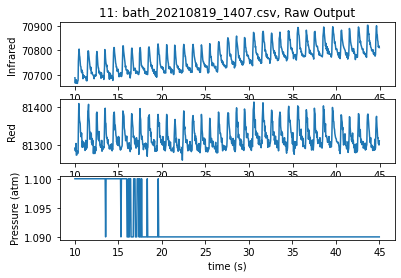

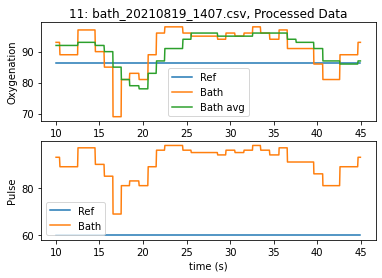

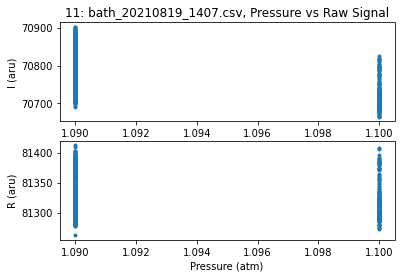

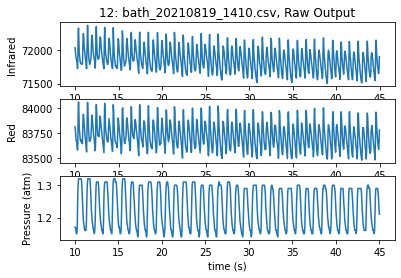

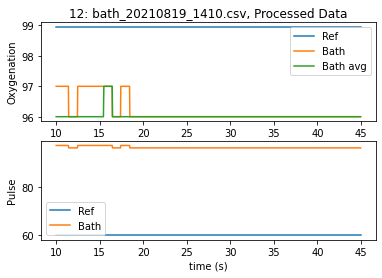

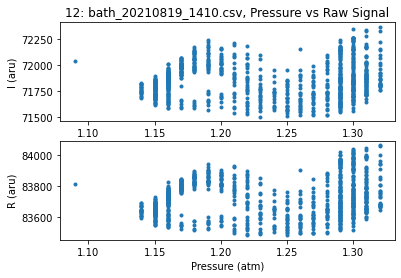

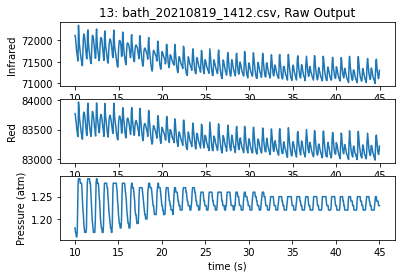

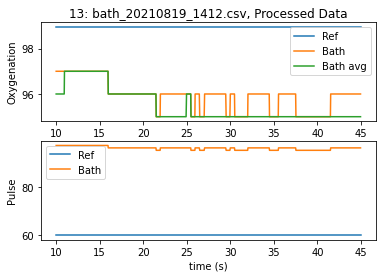

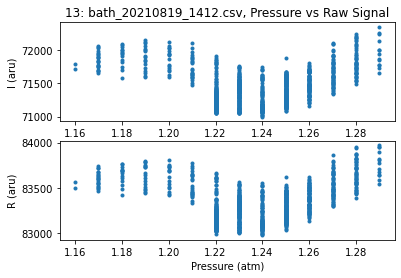

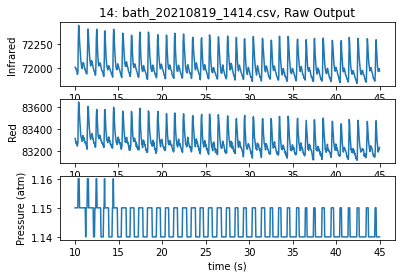

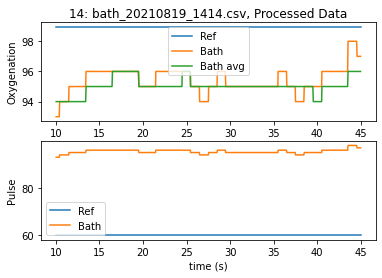

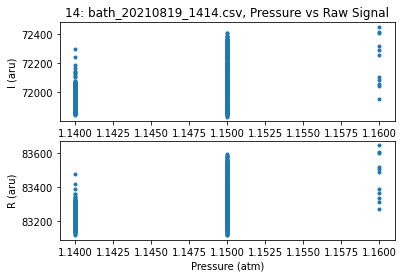

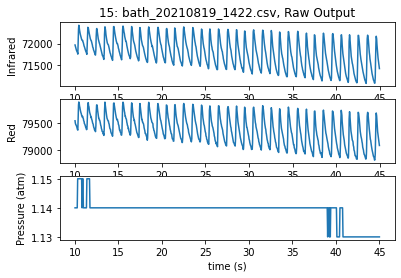

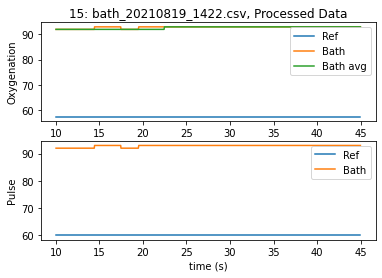

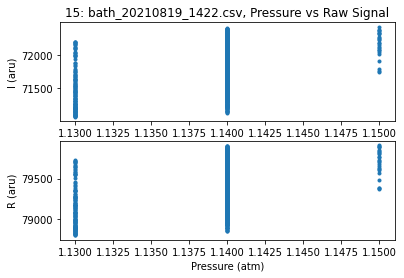

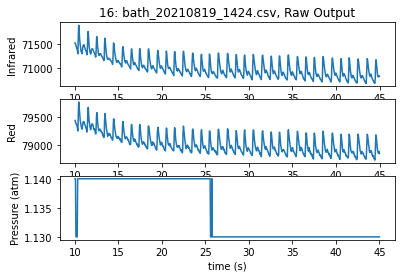

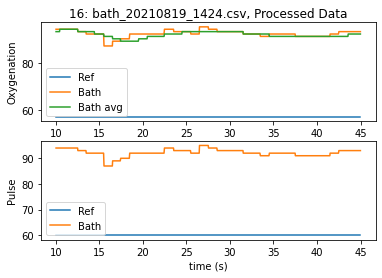

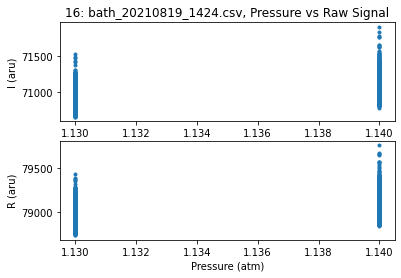

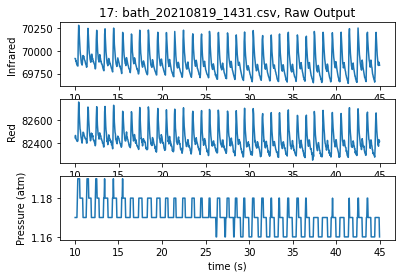

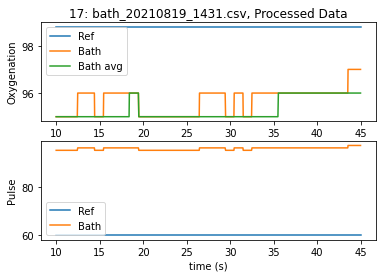

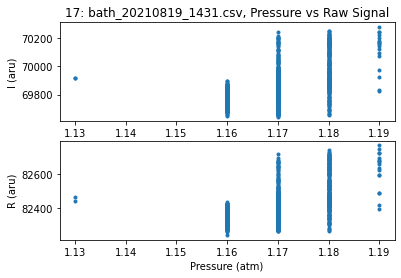

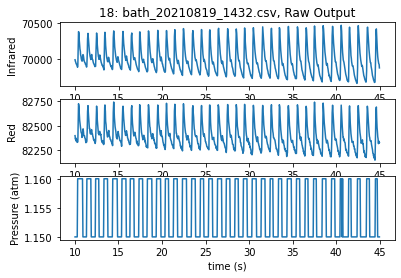

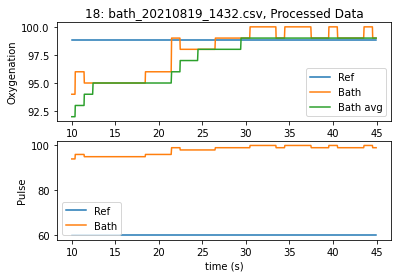

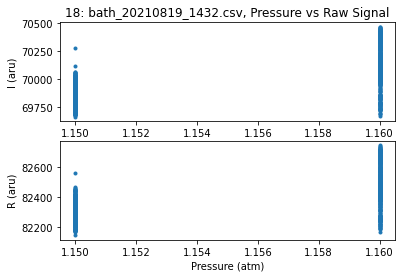

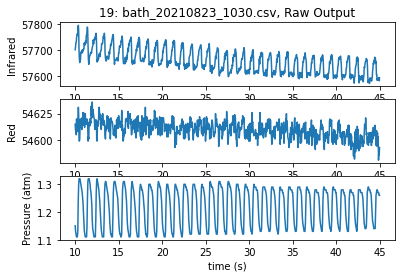

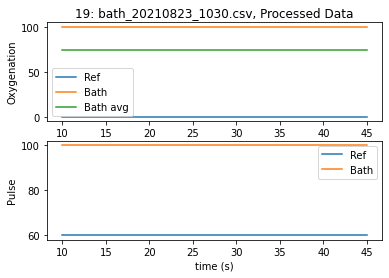

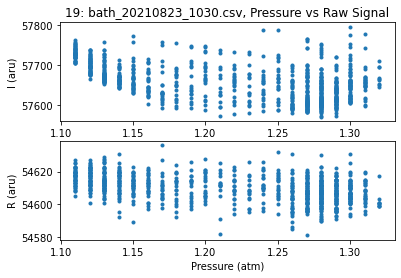

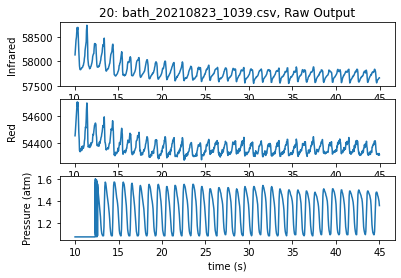

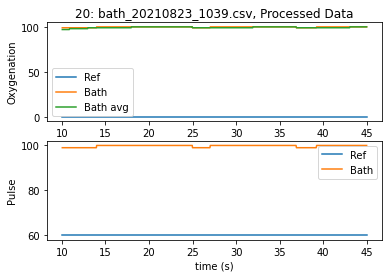

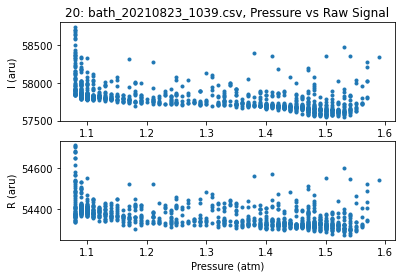

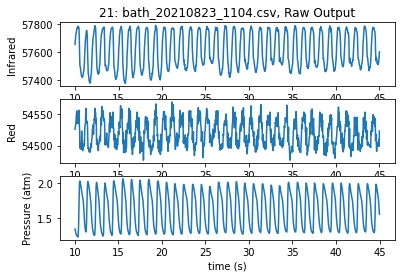

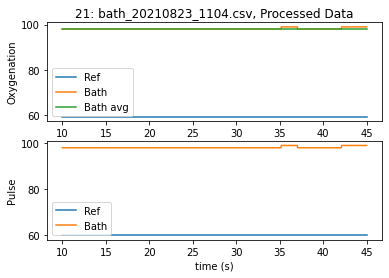

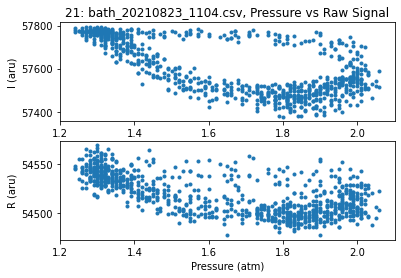

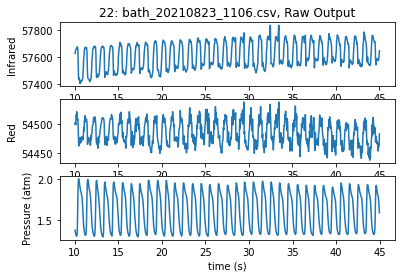

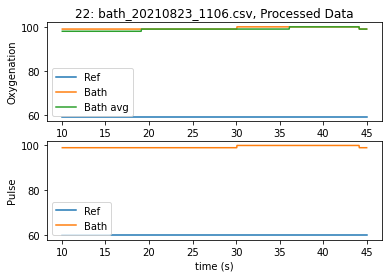

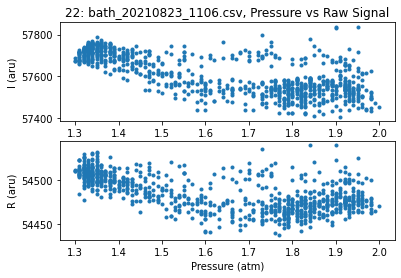

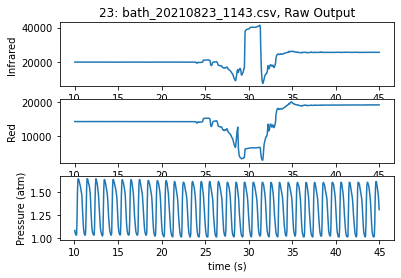

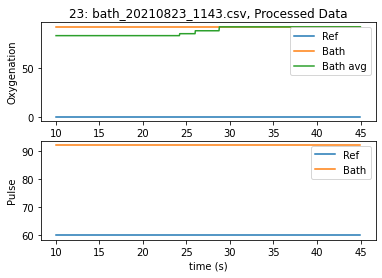

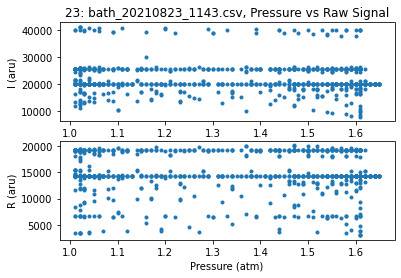

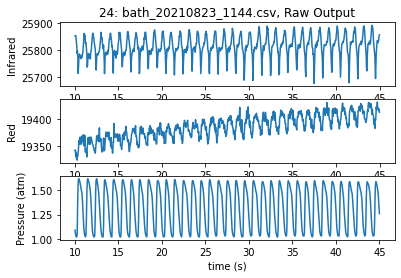

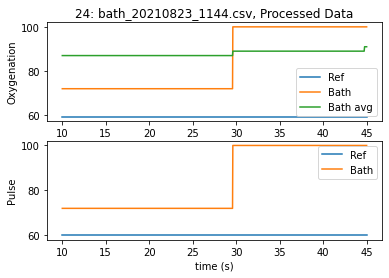

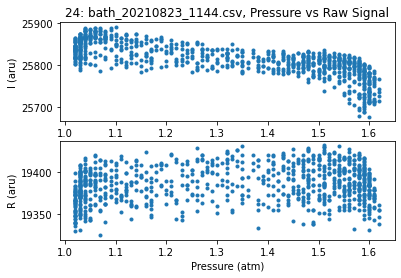

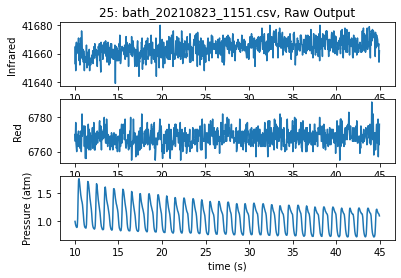

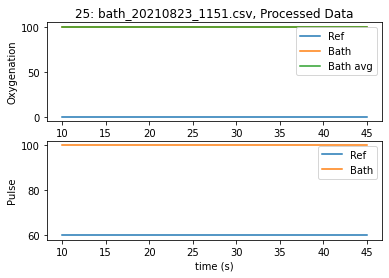

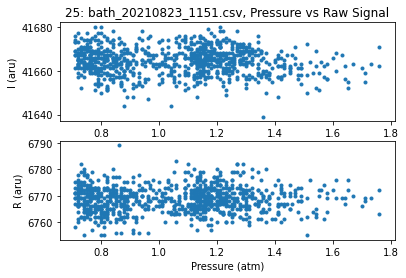

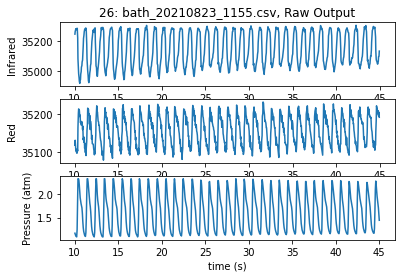

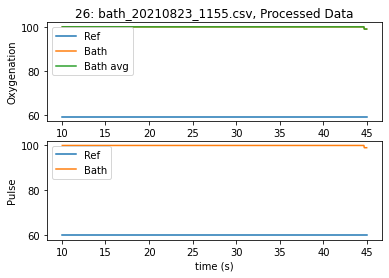

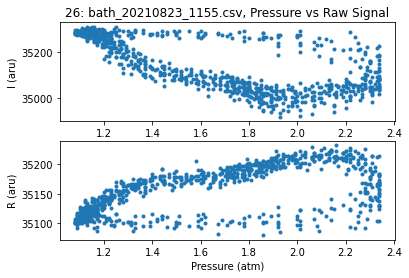

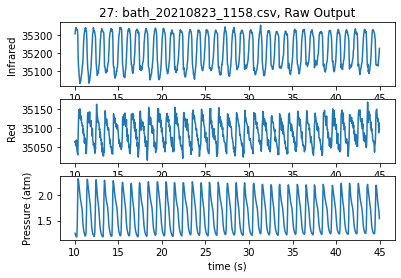

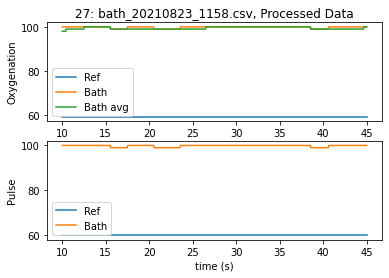

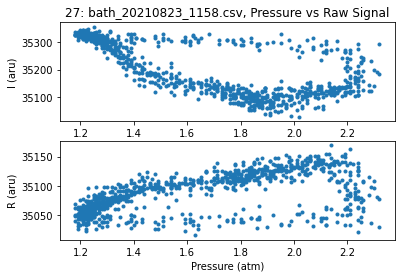

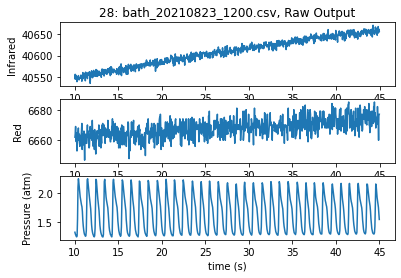

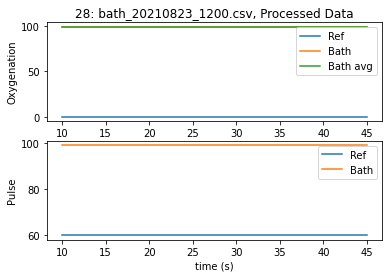

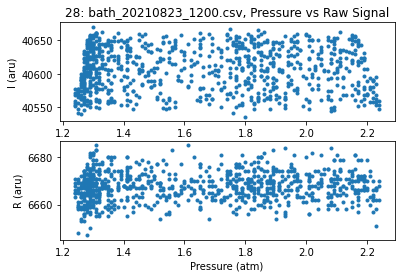

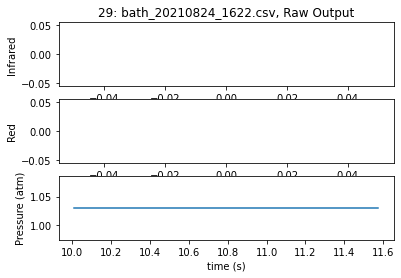

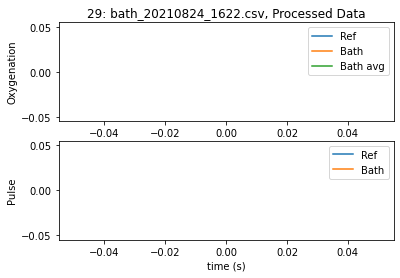

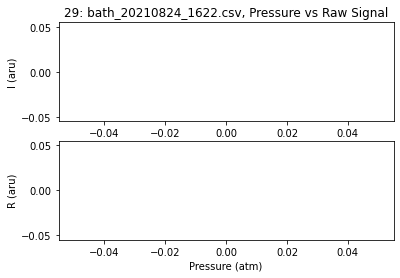

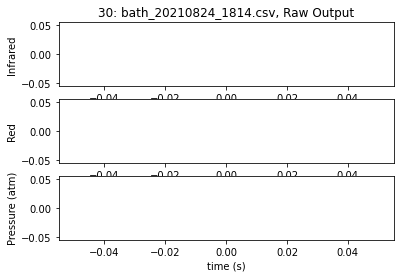

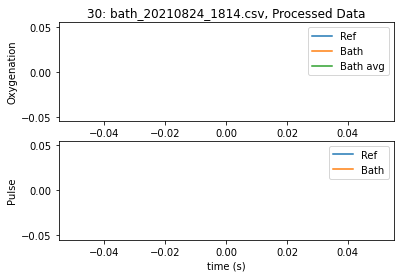

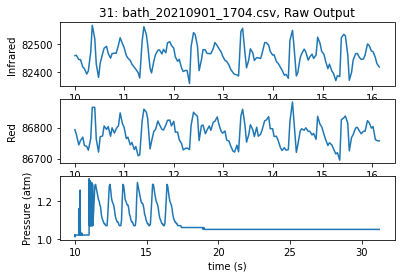

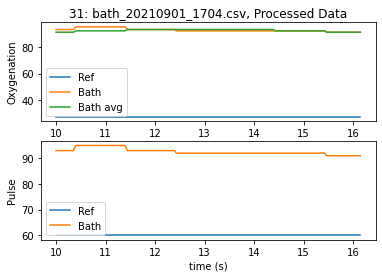

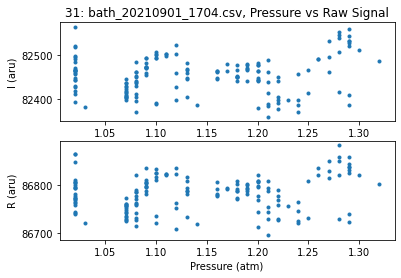

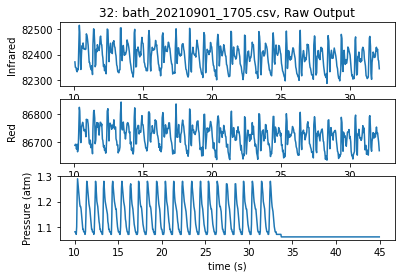

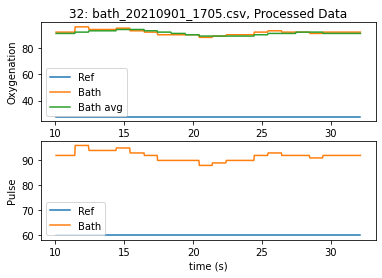

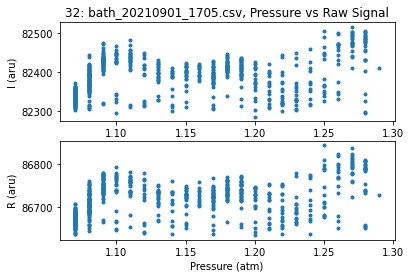

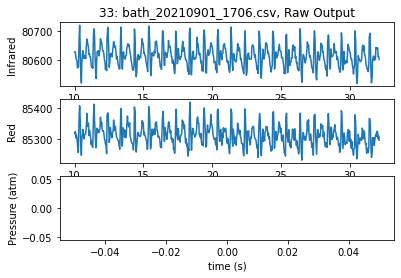

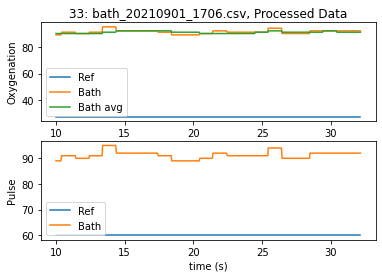

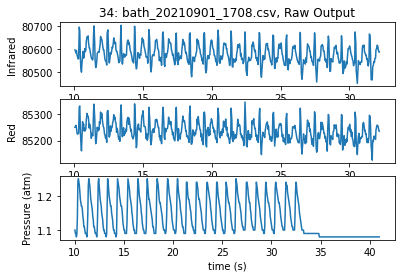

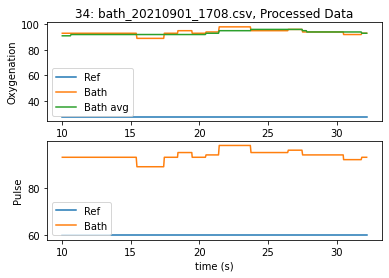

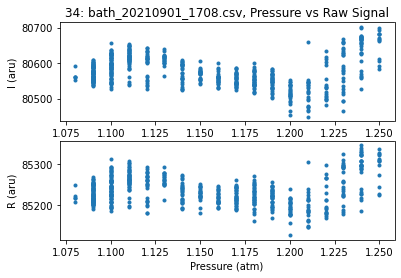

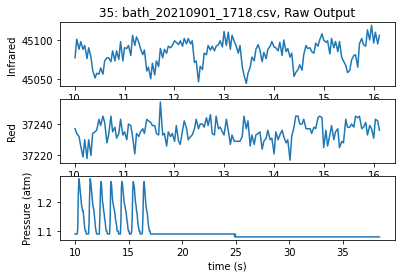

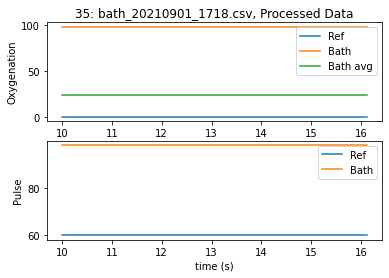

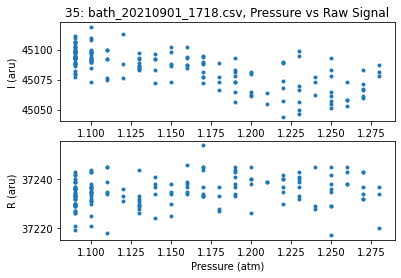

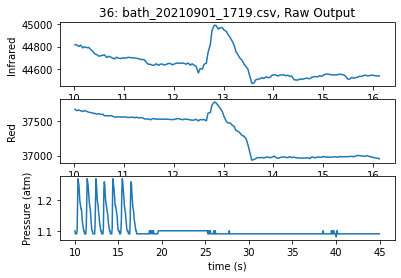

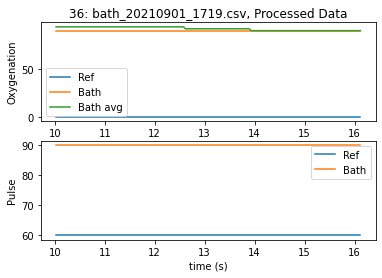

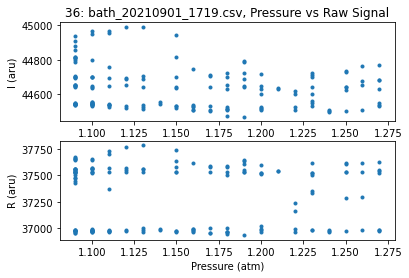

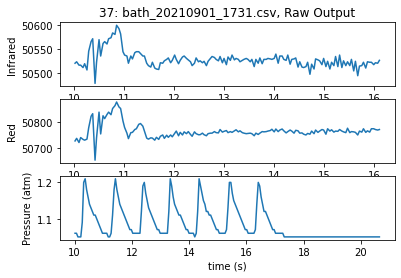

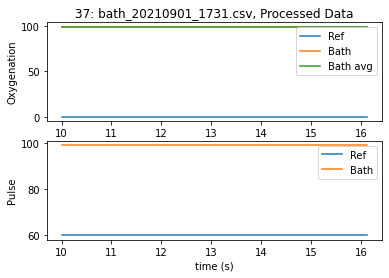

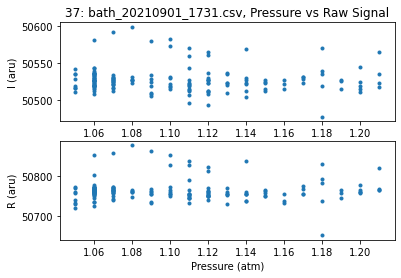

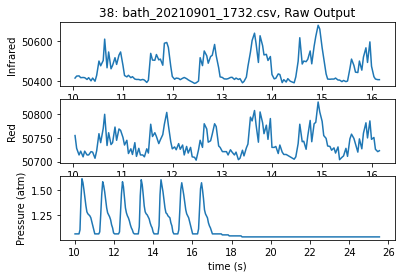

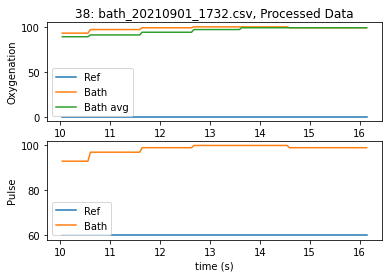

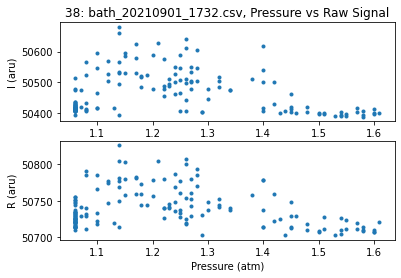

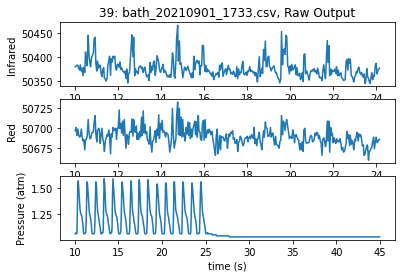

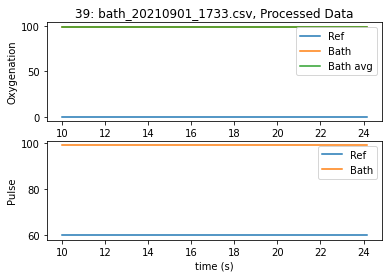

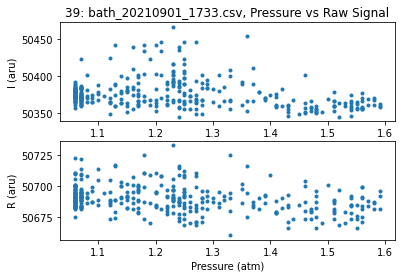

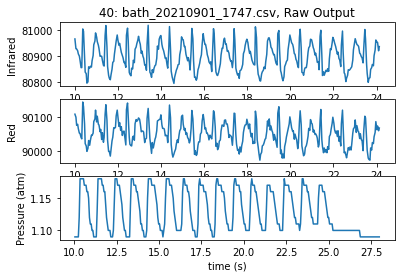

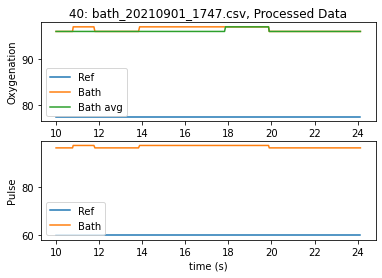

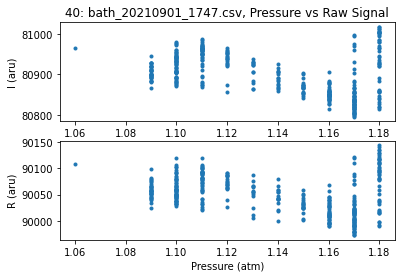

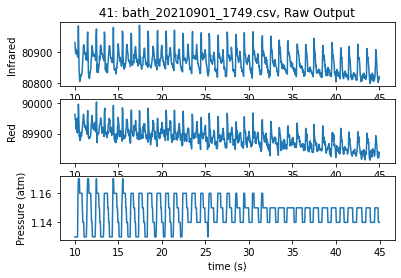

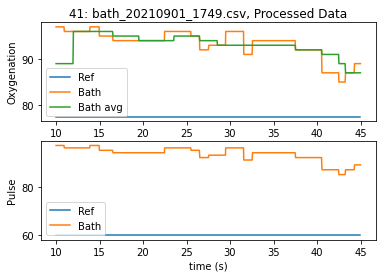

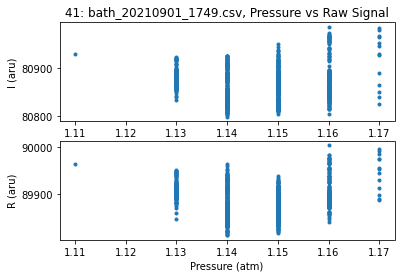

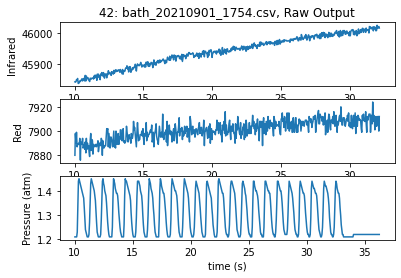

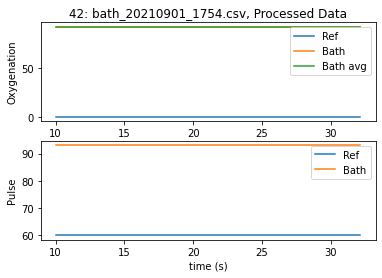

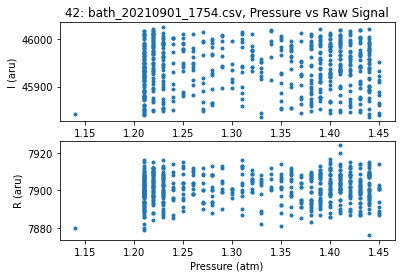

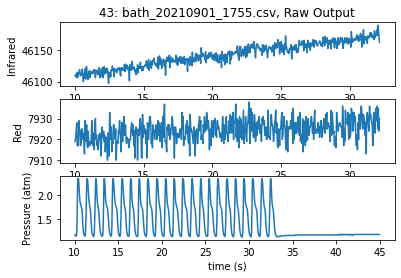

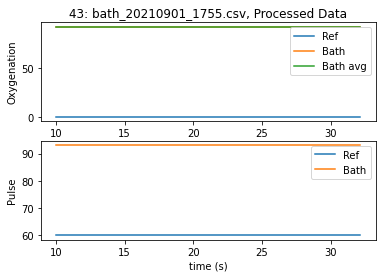

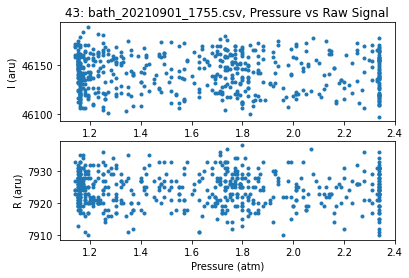

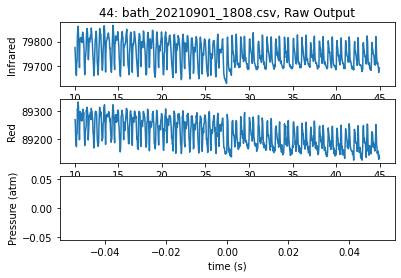

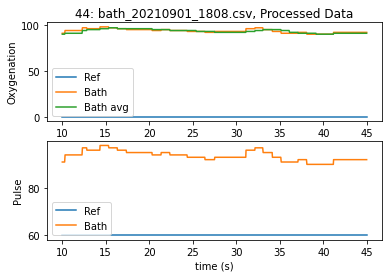

In [33]:
START = 10
END = 45

for plot_index, (name, b, p, o) in enumerate(matches[:]):

    name = os.path.split(name)[-1]

    t0 = b.utc_time[0]
    b['time'] = b.utc_time-t0
    p['time'] = p.utc_time-t0

    b = b[(START < b.time) & (b.time < END)]
    p = p[(START < p.time) & (p.time < END)]
    
    # Plot input parameters
    f, (ax1, ax2, ax3) = plt.subplots(3, 1)  # , sharey=True)

    ax1.plot(b.time, b.i)
    ax1.set_ylabel('Infrared')
    
    ax2.plot(b.time, b.r)
    ax2.set_ylabel('Red')

    ax3.plot(p.time, p.p)
    ax3.set_ylabel('Pressure (atm)')

    ax1.set_title('Input data')
    ax3.set_xlabel('time (s)')

    ax1.set_title(f'{plot_index}: {name}, Raw Output')

    # Plot output parameters
    f, (ax1, ax2) = plt.subplots(2, 1)  # , sharey=True)

    ax1.plot(b.time, np.ones_like(b.time)*severinghaus(o))
    ax1.plot(b.time, b.SPO2)
    ax1.plot(b.time, b.SPO2Avg)
    ax1.set_ylabel('Oxygenation')
    ax1.legend(['Ref', 'Bath', 'Bath avg'])
    
    ax2.plot(b.time, np.ones_like(b.time)*60)
    ax2.plot(b.time, b.SPO2)
    ax2.legend(['Ref', 'Bath'])
    ax2.set_ylabel('Pulse')

    ax1.set_title(f'{plot_index}: {name}, Processed Data')
    ax2.set_xlabel('time (s)')
    
    if len(p) > 0:
        
        f, (ax1, ax2) = plt.subplots(2, 1)  # , sharey=True)

        # place p into b data frame
        p_index = 0

        t_current = p.time.iloc[0]
        col = []
        for i, t in enumerate(b.time):
            while t > t_current:
                p_index = p_index + 1
                if p_index < len(p):
                    p_current, t_current = p.p.iloc[p_index], p.time.iloc[p_index]
                else:
                    break
            col.append(p_current)

        b.insert(loc=0, column='p', value=col)

        ax1.plot(b.p, b.i, '.')
        ax2.plot(b.p, b.r, '.')
        ax1.set_ylabel('I (aru)')
        ax2.set_ylabel('R (aru)')
        ax2.set_xlabel('Pressure (atm)')

        ax1.set_title(f'{plot_index}: {name}, Pressure vs Raw Signal')